# Importing libraries

In [1]:
import cv2
import io
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests

# Loading image

In [2]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Broadway_tower_edit.jpg/800px-Broadway_tower_edit.jpg'

with open('image.jpg', 'wb') as o:
    content = requests.get(image_url).content
    o.write(content)

original_img = cv2.imread('image.jpg')
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

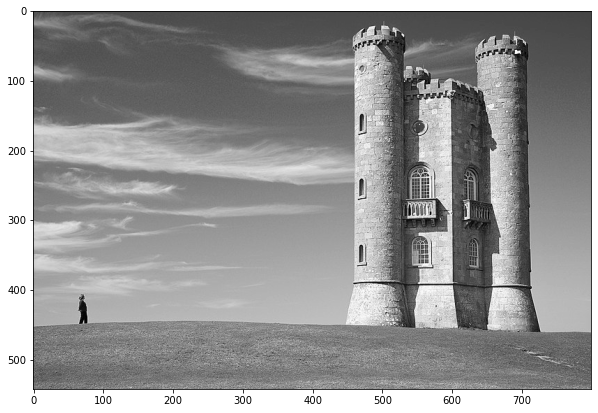

In [3]:
plt.figure(figsize=(10, 8))
plt.imshow(gray_img, cmap='gray')
plt.show()

# Carving

## Finding energy map

In [4]:
def get_energy(gray_img):
    # Kernel for computing gradient w.r.t x
    kx = np.array(
      [[-0.5, 0., 0.5],
       [-1.,  0., 1.],
       [-0.5, 0., 0.5]]
    )

    # Kernel for computing gradient w.r.t y
    ky = np.array(
      [[-0.5, -1., -0.5],
       [0.,   0., 0.],
       [0.5,  1., 0.5]]
    )

    dx = cv2.filter2D(gray_img, -1, kx)
    dy = cv2.filter2D(gray_img, -1, ky)

    energy = dx^2 + dy^2
    return energy

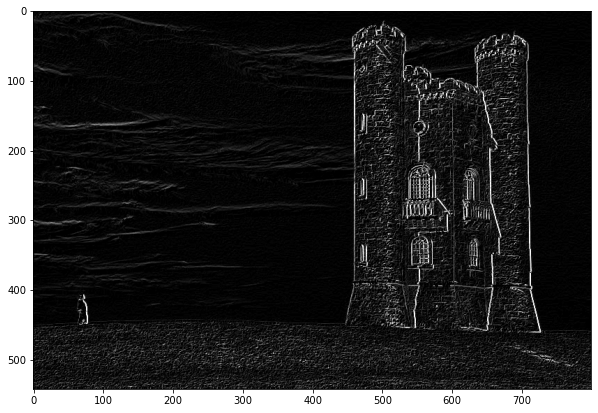

In [5]:
energy = get_energy(gray_img)
plt.figure(figsize=(10, 8))
plt.imshow(energy, cmap='gray')
plt.show()

## Finding min seam

In [6]:
def get_seam(energy, result_type='mask'):
    """Search for minimum total energy seam from `energy` using dynamic
    programming.

    Returns a tuple (min_downward_energy, path), where:
    * min_downward_energy[i, j]: the minumum total energy starting from pixel
    [i, j] down to bottom
    * path[i, j]: the column of the next pixel of [i, j] in the seam, i.e. the
    next pixel for [i, j] is [i+1, path[i, j]]
    """

    num_rows, num_cols = energy.shape

    min_downward_energy = np.zeros_like(energy, dtype=np.int64)
    path = np.zeros_like(energy, dtype=np.int64)

    # Initializing
    min_downward_energy[-1, :] = energy[-1, :].copy()
    base_idx = np.arange(-1, num_cols-1)

    for i in reversed(range(num_rows-1)):
        # These arrays store the values that are below left, below middle, or
        # below right to the values in the ith row
        lefts = np.hstack([np.inf, min_downward_energy[i+1, :-1]])
        middles = min_downward_energy[i+1]
        rights = np.hstack([min_downward_energy[i+1, 1:], np.inf])

        # The indices of the minimum elements among the below left, middle and right
        # of each element in the ith row
        min_idx = np.argmin([lefts, middles, rights], axis=0) + base_idx

        # Updates
        min_downward_energy[i] = energy[i] + min_downward_energy[i+1, min_idx]
        path[i] = min_idx

    # Extracting minimum seam from path
    seam = []
    j = np.argmin(min_downward_energy[0, :])
    i = 0
    while i < num_rows:
        seam.append(j)
        j = path[i, j]
        i += 1

    if result_type == 'mask':
        res = np.zeros_like(energy, dtype=bool)
        res[np.arange(num_rows), seam] = 1
        seam = res
    else:
        seam = np.array(seam)

    return seam

### Utilities

In [7]:
def add_seam_to_image(img, seam_mask):
    """Return a new image with all pixels in the seam stored in `seam_mask` turned
    into magenta.
    """
    with_seam = img.copy()
    # Convert grayscale image to RGB space
    if len(img.shape) == 2:
        with_seam = np.stack([with_seam] * 3, axis=2)

    magenta = np.stack([seam_mask * 255, seam_mask * 0, seam_mask * 255], axis=2)
    with_seam = with_seam * (1 - seam_mask[..., np.newaxis]) + magenta
    return with_seam.astype(np.uint8)

In [8]:
def bgr_rgb(img):
    """Switch back and forth between BGR-formatted and RGB-formatted image
    """
    res = np.empty_like(img)
    res[:, :, 0] = img[:, :, 2].copy()
    res[:, :, 1] = img[:, :, 1].copy()
    res[:, :, 2] = img[:, :, 0].copy()
    return res

### Testing

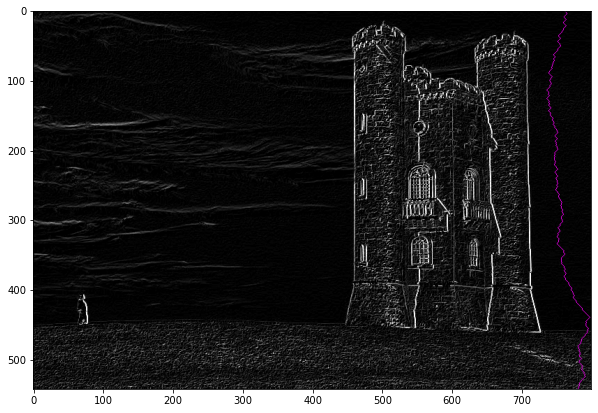

In [9]:
# Find minimum seam
mask = get_seam(energy, result_type='mask')

# Add the seam to the image
with_seam = add_seam_to_image(energy, mask)

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(with_seam)
plt.show()

## Carving

In [10]:
def carve(img, mask):
    """Remove the seam from image
    """
    
    shape = list(img.shape)

    # Reduce one pixel in column
    shape[1] -= 1

    new_img = np.empty(shape, dtype=img.dtype)
    num_rows = shape[0]
    dim = len(shape)

    # 2D (or grayscale) image
    if dim == 2:
        for i in range(num_rows):
            new_img[i, :] = img[i, :][~mask[i, :]]
    # 3D image
    else:
        for i in range(num_rows):
            new_img[i, :, :] = img[i, :, :][~mask[i, :]]

    return new_img

## Resizing

In [11]:
def resize(img, num_seams, axis=1, create_gif=False, gif_file_name=None):
    im = img.copy()
    if axis == 0:
        im = cv2.rotate(im, cv2.cv2.ROTATE_90_CLOCKWISE)

    dim = len(img.shape)
    num_digits = int(np.log10(num_seams)) + 1
    gif_frames = []

    # Maintain a separate grayscale image to compute energy and find seam
    if dim == 3:
        gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # Otherwise, the source image is already in grayscale and will be directly
    # used to find seam
    else:
        gray_im = im

    for i in range(num_seams):
        energy = get_energy(gray_im)
        seam = get_seam(energy)

        if create_gif:
            with_seam = add_seam_to_image(im, seam)
            
            # Add a white padding to the right of each resized frame
            col_delta = img.shape[1] - with_seam.shape[1]
            if col_delta > 0:
                white_padding = np.full(
                    shape=(im.shape[0], col_delta, im.shape[2]),
                    fill_value=255,
                    dtype=with_seam.dtype
                )
                with_seam = np.hstack([with_seam, white_padding])
            
            # Encode each frame
            is_success, buffer = cv2.imencode('.jpg', with_seam)
            buffer = io.BytesIO(buffer)
            
            # Open each frame as a PIL.Image
            frame = Image.open(buffer)
            gif_frames.append(frame)

        im = carve(im, seam)
        # Only carve gray_im if it's a separate image from im
        if dim == 3:
            gray_im = carve(gray_im, seam)

    if create_gif:
        # Export as a GIF file
        frame = gif_frames[0]
        frame.save(fp=gif_file_name, format='GIF', append_images=gif_frames, save_all=True, duration=200, loop=0)

    return im if axis == 1 else cv2.rotate(im, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

### Reducing width

In [12]:
%%time
reduced_width = resize(original_img, num_seams=50, axis=1, create_gif=True, gif_file_name='reducing-width.gif')
original_img.shape, reduced_width.shape

CPU times: user 6.26 s, sys: 539 ms, total: 6.8 s
Wall time: 6.84 s


((542, 800, 3), (542, 750, 3))

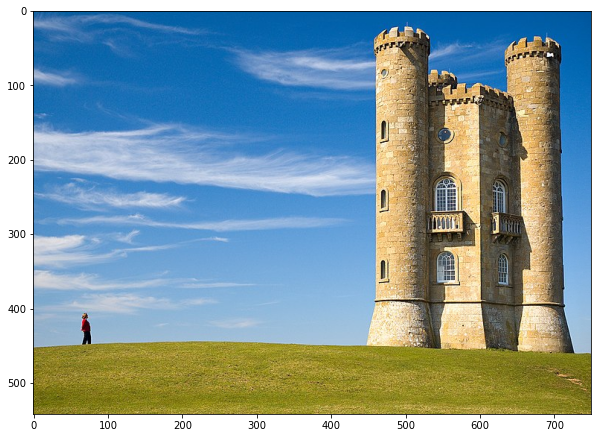

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_width))
plt.show()

### Reducing height

In [14]:
%%time
reduced_height = resize(original_img, num_seams=50, axis=0, create_gif=True, gif_file_name='reducing-height.gif')
original_img.shape, reduced_height.shape

CPU times: user 7.71 s, sys: 490 ms, total: 8.21 s
Wall time: 8.26 s


((542, 800, 3), (492, 800, 3))

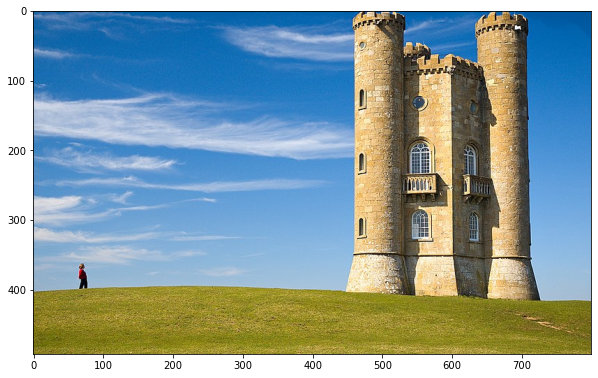

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(bgr_rgb(reduced_height))
plt.show()